In [1]:
import pandas as pd
import numpy as np
import re
import math
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from geopy import distance
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import geopandas as gpd

In [2]:
transaction = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='Transactions')
cust_demographic = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerDemographic')
cust_address = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='CustomerAddress')
new_cust = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name='NewCustomerList')

In [3]:
transaction.head()

transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  standard_cost  product_first_sold_date  
0       71.49          53.62                  41245.0  
1     2091.47         388.92                  41701.0  
2     1793.43         248.82                  36361.0  
3     1198.46         381.10                  36145.0  
4     1765.30         709.48                  42226.0

In [4]:
transaction.shape

(20000, 13)

In [5]:
cust_demographic.shape

(4000, 13)

In [6]:
cust_address.shape

(3999, 6)

### Data Quality

In [7]:


def dataQuality(data):
    d={}
    def numeric_quality(data):
        def q1(x):
            return x.quantile(0.25)
        def q3(x):
            return x.quantile(0.75)
        def q99(x):
            return x.quantile(0.99)
        def count(x):
            return x.count()
        def miss_per(x):
            return x.isnull().sum()/len(x)
        def unique(x):
            return len(x.unique())
        qr=dict()
        #select only numeric data types
        data=data.select_dtypes(include=[np.number])
        for i in np.arange(0,len(data.columns),1):
            xi=data.agg({data.columns[i]:
                        [count,unique,miss_per,np.min,np.max,np.mean,np.median,np.std,np.var,q1,q3,q99]
                        })
            qr[data.columns[i]]=xi.reset_index(drop=True)[data.columns[i]]
            df1=pd.DataFrame(qr)
            #df1.index=xi.index
        
        df1.index=["count","unique","Miss_per","Min","Max",
                   "Mean","Median","Std","Var","Q1","Q3","q99"]
        return df1.T
    d['numeric']=numeric_quality(data)
        
    def cat_quality(data):
        def count(x):
            return x.count()
        def miss_per(x):
            return x.isnull().sum()/len(x)
        def unique(x):
            return len(x.unique())
        def freq_cat(x):
            return x.value_counts().sort_values(ascending=False).index[0]
        def freq_cat_per(x):
            return x.value_counts().sort_values(ascending=False).index[0]/len(x)
        qr=dict()
        #select only categorical data types
        data=data.select_dtypes(include=[object])
        for i in np.arange(0,len(data.columns),1):
            xi=data.agg({data.columns[i]:[count,unique,miss_per,freq_cat]})
            qr[data.columns[i]]=xi.reset_index(drop=True)[data.columns[i]]
            df2=pd.DataFrame(qr)
            #df2.index=xi.index
        df2.index=["count","Unique","Miss_per","Freq_Level"]
        return df2.T
    d['categorical']=cat_quality(data)
    return d

#### Transaction

In [8]:
print("Data quality : Numeric variables")
(dataQuality(transaction)['numeric'])

Data quality : Numeric variables


count   unique  Miss_per       Min       Max  \
transaction_id           20000.0  20000.0   0.00000      1.00  20000.00   
product_id               20000.0    101.0   0.00000      0.00    100.00   
customer_id              20000.0   3494.0   0.00000      1.00   5034.00   
online_order             19640.0      3.0   0.01800      0.00      1.00   
list_price               20000.0    296.0   0.00000     12.01   2091.47   
standard_cost            19803.0    104.0   0.00985      7.21   1759.85   
product_first_sold_date  19803.0    101.0   0.00985  33259.00  42710.00   

                                 Mean    Median          Std           Var  \
transaction_id           10000.500000  10000.50  5773.647028  3.333500e+07   
product_id                  45.364650     44.00    30.753590  9.457833e+02   
customer_id               1738.246050   1736.00  1011.951046  1.024045e+06   
online_order                 0.500458      1.00     0.500013  2.500125e-01   
list_price                1107.829449   1163.89   582.825242  3.396853e+05   
standard_cost              556.046951    507.58   405.955660  1.648000e+05   
product_first_sold_date  38199.776549  38216.00  2875.201110  8.266781e+06   

                               Q1        Q3       q99  
transaction_id            5000.75  15000.25  19800.01  
product_id                  18.00     72.00     99.00  
customer_id                857.75   2613.00   3462.01  
online_order                 0.00      1.00      1.00  
list_price                 575.27   1635.30   2091.47  
standard_cost              215.14    795.10   1610.90  
product_first_sold_date  35667.00  40672.00  42710.00

In [9]:
print("Data quality : Categorical variables")
(dataQuality(transaction)['categorical'])

Data quality : Categorical variables


count Unique Miss_per Freq_Level
order_status   20000      2        0   Approved
brand          19803      7  0.00985      Solex
product_line   19803      5  0.00985   Standard
product_class  19803      4  0.00985     medium
product_size   19803      4  0.00985     medium

#### Customer Address

In [10]:
cust_address.dtypes

customer_id            int64
address               object
postcode               int64
state                 object
country               object
property_valuation     int64
dtype: object

In [11]:
print("Data quality : Numeric variables")
(dataQuality(cust_address)['numeric'])

Data quality : Numeric variables


count  unique  Miss_per     Min     Max         Mean  \
customer_id         3999.0  3999.0       0.0     1.0  4003.0  2003.987997   
postcode            3999.0   873.0       0.0  2000.0  4883.0  2985.755939   
property_valuation  3999.0    12.0       0.0     1.0    12.0     7.514379   

                    Median          Std           Var      Q1      Q3      q99  
customer_id         2004.0  1154.576912  1.333048e+06  1004.5  3003.5  3963.02  
postcode            2768.0   844.878364  7.138195e+05  2200.0  3750.0  4818.00  
property_valuation     8.0     2.824663  7.978720e+00     6.0    10.0    12.00

In [12]:
print("Data quality : Categorical variables")
(dataQuality(cust_address)['categorical'])

Data quality : Categorical variables


count Unique Miss_per        Freq_Level
address  3999   3996        0  3 Talisman Place
state    3999      5        0               NSW
country  3999      1        0         Australia

In [14]:
cust_address['state'].unique()

array(['New South Wales', 'QLD', 'VIC', 'NSW', 'Victoria'], dtype=object)

#### Customer Demographic

In [15]:
cust_demographic.dtypes

customer_id                                     int64
first_name                                     object
last_name                                      object
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                                      object
job_industry_category                          object
wealth_segment                                 object
deceased_indicator                             object
default                                        object
owns_car                                       object
tenure                                        float64
dtype: object

In [16]:

print("Data quality : Numeric variables")
(dataQuality(cust_demographic)['numeric'])

Data quality : Numeric variables


count  unique  Miss_per  Min     Max  \
customer_id                          4000.0  4000.0   0.00000  1.0  4000.0   
past_3_years_bike_related_purchases  4000.0   100.0   0.00000  0.0    99.0   
tenure                               3913.0    23.0   0.02175  1.0    22.0   

                                            Mean  Median          Std  \
customer_id                          2000.500000  2000.5  1154.844867   
past_3_years_bike_related_purchases    48.890000    48.0    28.715005   
tenure                                 10.657041    11.0     5.660146   

                                              Var       Q1       Q3      q99  
customer_id                          1.333667e+06  1000.75  3000.25  3960.01  
past_3_years_bike_related_purchases  8.245515e+02    24.00    73.00    99.00  
tenure                               3.203726e+01     6.00    15.00    22.00

In [17]:
print("Data quality : Categorical variables")
(dataQuality(cust_demographic)['categorical'])

Data quality : Categorical variables


count Unique Miss_per  \
first_name             4000   3139        0   
last_name              3875   3726  0.03125   
gender                 4000      6        0   
job_title              3494    196   0.1265   
job_industry_category  3344     10    0.164   
wealth_segment         4000      3        0   
deceased_indicator     4000      2        0   
default                3698     91   0.0755   
owns_car               4000      2        0   

                                                 Freq_Level  
first_name                                           Timmie  
last_name                                          Ramsdell  
gender                                               Female  
job_title              Business Systems Development Analyst  
job_industry_category                         Manufacturing  
wealth_segment                                Mass Customer  
deceased_indicator                                        N  
default                                                 100  
owns_car                                                Yes

In [20]:
cust_demographic['gender'].unique()

array(['F', 'Male', 'Female', 'U', 'Femal', 'M'], dtype=object)

#### New Customer

In [21]:
new_cust.head()

first_name  last_name  gender  past_3_years_bike_related_purchases  \
0    Chickie    Brister    Male                                   86   
1      Morly     Genery    Male                                   69   
2    Ardelis  Forrester  Female                                   10   
3     Lucine      Stutt  Female                                   64   
4    Melinda     Hadlee  Female                                   34   

         DOB                   job_title job_industry_category  \
0 1957-07-12             General Manager         Manufacturing   
1 1970-03-22         Structural Engineer              Property   
2 1974-08-28      Senior Cost Accountant    Financial Services   
3 1979-01-28  Account Representative III         Manufacturing   
4 1965-09-21           Financial Analyst    Financial Services   

      wealth_segment deceased_indicator owns_car  ...  state    country  \
0      Mass Customer                  N      Yes  ...    QLD  Australia   
1      Mass Customer                  N       No  ...    NSW  Australia   
2  Affluent Customer                  N       No  ...    VIC  Australia   
3  Affluent Customer                  N      Yes  ...    QLD  Australia   
4  Affluent Customer                  N       No  ...    NSW  Australia   

   property_valuation Unnamed: 16 Unnamed: 17  Unnamed: 18  Unnamed: 19  \
0                   6        0.58      0.7250      0.90625     0.770312   
1                  11        0.75      0.7500      0.93750     0.796875   
2                   5        0.40      0.4000      0.40000     0.400000   
3                   1        0.83      1.0375      1.03750     1.037500   
4                   9        0.98      0.9800      1.22500     1.225000   

   Unnamed: 20  Rank     Value  
0            1     1  1.718750  
1            1     1  1.718750  
2            1     1  1.718750  
3            4     4  1.703125  
4            4     4  1.703125  

[5 rows x 23 columns]

In [22]:
new_cust.dtypes

first_name                                     object
last_name                                      object
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                                      object
job_industry_category                          object
wealth_segment                                 object
deceased_indicator                             object
owns_car                                       object
tenure                                          int64
address                                        object
postcode                                        int64
state                                          object
country                                        object
property_valuation                              int64
Unnamed: 16                                   float64
Unnamed: 17                                   float64
Unnamed: 18                 

In [23]:
print("Data quality : Numerical variables")
(dataQuality(new_cust)['numeric'])

Data quality : Numerical variables


count  unique  Miss_per      Min  \
past_3_years_bike_related_purchases  1000.0   100.0       0.0     0.00   
tenure                               1000.0    23.0       0.0     0.00   
postcode                             1000.0   522.0       0.0  2000.00   
property_valuation                   1000.0    12.0       0.0     1.00   
Unnamed: 16                          1000.0    71.0       0.0     0.40   
Unnamed: 17                          1000.0   132.0       0.0     0.40   
Unnamed: 18                          1000.0   187.0       0.0     0.40   
Unnamed: 19                          1000.0   325.0       0.0     0.34   
Unnamed: 20                          1000.0   324.0       0.0     1.00   
Rank                                 1000.0   324.0       0.0     1.00   
Value                                1000.0   324.0       0.0     0.34   

                                            Max         Mean     Median  \
past_3_years_bike_related_purchases    99.00000    49.836000    51.0000   
tenure                                 22.00000    11.388000    11.0000   
postcode                             4879.00000  3019.227000  2800.0000   
property_valuation                     12.00000     7.397000     8.0000   
Unnamed: 16                             1.10000     0.752000     0.7500   
Unnamed: 17                             1.37500     0.844310     0.8375   
Unnamed: 18                             1.71875     0.948929     0.9250   
Unnamed: 19                             1.71875     0.875659     0.8500   
Unnamed: 20                          1000.00000   498.819000   500.0000   
Rank                                 1000.00000   498.819000   500.0000   
Value                                   1.71875     0.881714     0.8600   

                                            Std            Var           Q1  \
past_3_years_bike_related_purchases   27.796686     772.655760    26.750000   
tenure                                 5.037145      25.372829     7.000000   
postcode                             848.895767  720624.023494  2209.000000   
property_valuation                     2.758804       7.611002     6.000000   
Unnamed: 16                            0.203580       0.041445     0.587500   
Unnamed: 17                            0.247309       0.061162     0.637500   
Unnamed: 18                            0.294663       0.086826     0.712500   
Unnamed: 19                            0.279034       0.077860     0.658125   
Unnamed: 20                          288.810997   83411.792031   250.000000   
Rank                                 288.810997   83411.792031   250.000000   
Value                                  0.293525       0.086157     0.649531   

                                           Q3          q99  
past_3_years_bike_related_purchases    72.000    98.000000  
tenure                                 15.000    22.000000  
postcode                             3845.500  4740.040000  
property_valuation                      9.000    12.000000  
Unnamed: 16                             0.920     1.100000  
Unnamed: 17                             1.030     1.350000  
Unnamed: 18                             1.150     1.656250  
Unnamed: 19                             1.075     1.562656  
Unnamed: 20                           750.250   988.000000  
Rank                                  750.250   988.000000  
Value                                   1.075     1.640625

In [24]:
print("Data quality : Categorical variables")
print(dataQuality(new_cust)['categorical'])

Data quality : Categorical variables
                      count Unique Miss_per           Freq_Level
first_name             1000    940        0             Rozamond
last_name               971    962    0.029              Crellim
gender                 1000      3        0               Female
job_title               894    185    0.106  Associate Professor
job_industry_category   835     10    0.165   Financial Services
wealth_segment         1000      3        0        Mass Customer
deceased_indicator     1000      1        0                    N
owns_car               1000      2        0                   No
address                1000   1000        0   5864 Mcbride Trail
state                  1000      3        0                  NSW
country                1000      1        0            Australia


### Data Cleaning

In [25]:
now=pd.to_datetime('now')
new_cust['age']=(now - new_cust['DOB']).astype('<m8[Y]')
cust_demographic['age']=(now - cust_demographic['DOB']).astype('<m8[Y]')

In [26]:
def states(x):
    #print(x)
    if(re.findall("New South Wales",x)):
        return 'NSW'
    elif(re.findall("Victoria",x)):
        return 'VIC'
    else:
        return x

In [27]:
cust_address['state']=cust_address['state'].apply(lambda x:states(x))

In [28]:
def gender(x):
    if(re.findall("^F",x)):
        return 'Female'
    elif(re.findall("^M",x)):
        return 'Male'
    elif(re.findall("^U",x)):
        return 'Unknown'
    else:
        return x

In [29]:
cust_demographic['gender']=cust_demographic['gender'].apply(lambda x:gender(x))

In [30]:
new_cust['gender']=new_cust['gender'].apply(lambda x:gender(x))

In [31]:
new_cust.drop(['Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20','country','DOB'],axis=1,inplace=True)
cust_demographic.drop(['DOB','default'],axis=1,inplace=True)
cust_address.drop(['country'],axis=1,inplace=True)

In [32]:
cust_demographic.first_name.isnull().sum()

0

In [30]:
#for index, row in cust_demographic.iterrows():
#    if cust_demographic.last_name.isnan():
#        cust_demographic['name']=cust_demographic['first_name']
#    else:
#        cust_demographic['name']=cust_demographic['first_name']+" "+cust_demographic['last_name']
#    
#cust_demographic.drop(['first_name','last_name'],axis=1,inplace=True)
#cust_demographic.head()

In [33]:
cust_address.head()

customer_id              address  postcode state  property_valuation
0            1   060 Morning Avenue      2016   NSW                  10
1            2  6 Meadow Vale Court      2153   NSW                  10
2            4   0 Holy Cross Court      4211   QLD                   9
3            5  17979 Del Mar Point      2448   NSW                   4
4            6     9 Oakridge Court      3216   VIC                   9

In [34]:
cust_demographic.head()

customer_id      first_name  last_name  gender  \
0            1         Laraine  Medendorp  Female   
1            2             Eli    Bockman    Male   
2            3           Arlin     Dearle    Male   
3            4          Talbot        NaN    Male   
4            5  Sheila-kathryn     Calton  Female   

   past_3_years_bike_related_purchases               job_title  \
0                                   93     Executive Secretary   
1                                   81  Administrative Officer   
2                                   61      Recruiting Manager   
3                                   33                     NaN   
4                                   56           Senior Editor   

  job_industry_category     wealth_segment deceased_indicator owns_car  \
0                Health      Mass Customer                  N      Yes   
1    Financial Services      Mass Customer                  N      Yes   
2              Property      Mass Customer                  N      Yes   
3                    IT      Mass Customer                  N       No   
4                   NaN  Affluent Customer                  N      Yes   

   tenure   age  
0    11.0  66.0  
1    16.0  39.0  
2    15.0  66.0  
3     7.0  58.0  
4     8.0  43.0

In [35]:
new_cust.head()

first_name  last_name  gender  past_3_years_bike_related_purchases  \
0    Chickie    Brister    Male                                   86   
1      Morly     Genery    Male                                   69   
2    Ardelis  Forrester  Female                                   10   
3     Lucine      Stutt  Female                                   64   
4    Melinda     Hadlee  Female                                   34   

                    job_title job_industry_category     wealth_segment  \
0             General Manager         Manufacturing      Mass Customer   
1         Structural Engineer              Property      Mass Customer   
2      Senior Cost Accountant    Financial Services  Affluent Customer   
3  Account Representative III         Manufacturing  Affluent Customer   
4           Financial Analyst    Financial Services  Affluent Customer   

  deceased_indicator owns_car  tenure              address  postcode state  \
0                  N      Yes      14     45 Shopko Center      4500   QLD   
1                  N       No      16    14 Mccormick Park      2113   NSW   
2                  N       No      10  5 Colorado Crossing      3505   VIC   
3                  N      Yes       5   207 Annamark Plaza      4814   QLD   
4                  N       No      19    115 Montana Place      2093   NSW   

   property_valuation  Rank     Value   age  
0                   6     1  1.718750  63.0  
1                  11     1  1.718750  50.0  
2                   5     1  1.718750  46.0  
3                   1     4  1.703125  41.0  
4                   9     4  1.703125  55.0

In [36]:
merged_cust_data=cust_demographic.merge(cust_address, on='customer_id')

In [37]:
pd.options.display.max_columns = None
merged_cust_data

customer_id      first_name  last_name   gender  \
0               1         Laraine  Medendorp   Female   
1               2             Eli    Bockman     Male   
2               4          Talbot        NaN     Male   
3               5  Sheila-kathryn     Calton   Female   
4               6            Curr  Duckhouse     Male   
...           ...             ...        ...      ...   
3991         3996         Rosalia   Halgarth   Female   
3992         3997          Blanch     Nisuis   Female   
3993         3998          Sarene    Woolley  Unknown   
3994         3999       Patrizius        NaN     Male   
3995         4000           Kippy    Oldland     Male   

      past_3_years_bike_related_purchases               job_title  \
0                                      93     Executive Secretary   
1                                      81  Administrative Officer   
2                                      33                     NaN   
3                                      56           Senior Editor   
4                                      35                     NaN   
...                                   ...                     ...   
3991                                    8   VP Product Management   
3992                                   87         Statistician II   
3993                                   60       Assistant Manager   
3994                                   11                     NaN   
3995                                   76    Software Engineer IV   

     job_industry_category     wealth_segment deceased_indicator owns_car  \
0                   Health      Mass Customer                  N      Yes   
1       Financial Services      Mass Customer                  N      Yes   
2                       IT      Mass Customer                  N       No   
3                      NaN  Affluent Customer                  N      Yes   
4                   Retail     High Net Worth                  N      Yes   
...                    ...                ...                ...      ...   
3991                Health      Mass Customer                  N       No   
3992         Manufacturing     High Net Worth                  N      Yes   
3993                    IT     High Net Worth                  N       No   
3994         Manufacturing  Affluent Customer                  N      Yes   
3995                   NaN  Affluent Customer                  N       No   

      tenure   age                    address  postcode state  \
0       11.0  66.0         060 Morning Avenue      2016   NSW   
1       16.0  39.0        6 Meadow Vale Court      2153   NSW   
2        7.0  58.0         0 Holy Cross Court      4211   QLD   
3        8.0  43.0        17979 Del Mar Point      2448   NSW   
4       13.0  54.0           9 Oakridge Court      3216   VIC   
...      ...   ...                        ...       ...   ...   
3991    19.0  45.0         0 Transport Center      3977   VIC   
3992     1.0  19.0        4 Dovetail Crossing      2350   NSW   
3993     NaN   NaN       736 Roxbury Junction      2540   NSW   
3994    10.0  46.0            1482 Hauk Trail      3064   VIC   
3995    11.0  28.0  57042 Village Green Point      4511   QLD   

      property_valuation  
0                     10  
1                     10  
2                      9  
3                      4  
4                      9  
...                  ...  
3991                   6  
3992                   2  
3993                   6  
3994                   3  
3995                   6  

[3996 rows x 16 columns]

In [38]:
merged_cust_data.shape

(3996, 16)

In [39]:
transaction.sort_values("customer_id")

transaction_id  product_id  customer_id transaction_date  online_order  \
14485           14486          23            1       2017-03-27           0.0   
18969           18970          11            1       2017-03-29           1.0   
16422           16423           9            1       2017-12-09           1.0   
5156             5157          47            1       2017-05-11           1.0   
13423           13424           2            1       2017-02-21           0.0   
...               ...         ...          ...              ...           ...   
2462             2463           2         3500       2017-04-25           0.0   
8415             8416          74         3500       2017-02-16           0.0   
8707             8708           0         5034       2017-10-07           0.0   
16700           16701           0         5034       2017-01-27           0.0   
17468           17469           0         5034       2017-01-03           0.0   

      order_status           brand product_line product_class product_size  \
14485     Approved  Norco Bicycles     Mountain           low        small   
18969     Approved  Giant Bicycles     Standard          high       medium   
16422     Approved      OHM Cycles         Road        medium       medium   
5156      Approved   Trek Bicycles         Road           low        small   
13423     Approved           Solex     Standard        medium       medium   
...            ...             ...          ...           ...          ...   
2462      Approved           Solex     Standard        medium       medium   
8415      Approved        WeareA2B     Standard        medium       medium   
8707      Approved           Solex         Road        medium       medium   
16700     Approved  Norco Bicycles     Standard        medium       medium   
17468     Approved      OHM Cycles         Road        medium       medium   

       list_price  standard_cost  product_first_sold_date  
14485      688.63     612.880000                  33455.0  
18969     1274.93     764.960000                  35378.0  
16422      742.54     667.400000                  37838.0  
5156      1720.70    1531.420000                  37823.0  
13423       71.49      53.620000                  38573.0  
...           ...            ...                      ...  
2462        71.49      53.620000                  41245.0  
8415      1228.07     400.910000                  36668.0  
8707       416.98     312.735016                  42218.0  
16700      360.40     270.299988                  35667.0  
17468      742.54     667.400024                  33879.0  

[20000 rows x 13 columns]

In [40]:
transaction.to_excel('transaction.xlsx')

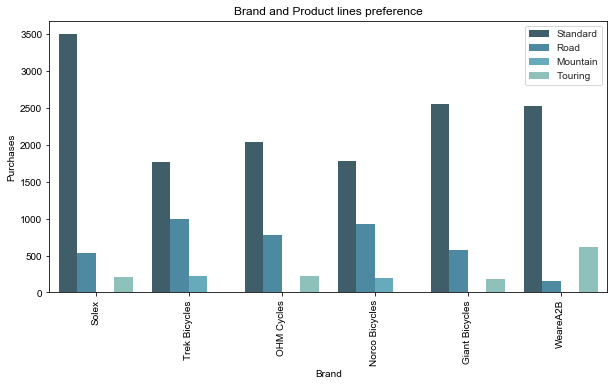

In [38]:
plt.figure(figsize=(10,5))
sns.countplot(x='brand',data=transaction,hue='product_line',palette='GnBu_d')
sns.set_style('ticks')
plt.legend(loc='upper right')
plt.title("Brand and Product lines preference")
plt.xlabel("Brand")
plt.ylabel("Purchases")
plt.xticks(rotation=90)
plt.show()

#### Trek Bicycles and Norco Bicycles are prefered Brands for Mountain product lines. And for the same brands, the touring product lines are not preferred by the customers.
#### Solex is the most preferred brand for standard bicycles followed by Giant Bicycles.

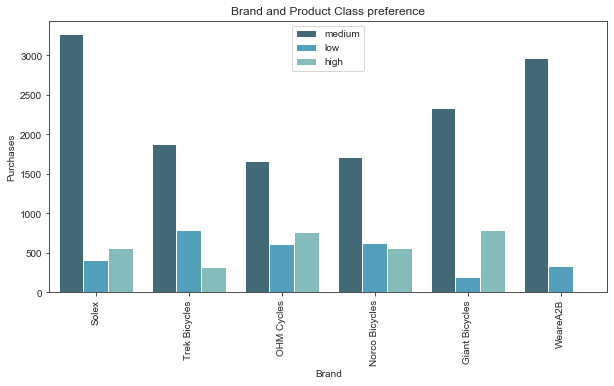

In [39]:
plt.figure(figsize=(10,5))
sns.countplot(x='brand',data=transaction,hue='product_class',palette='GnBu_d')
sns.set_style('ticks')
plt.legend(loc='upper center')
plt.title("Brand and Product Class preference")
plt.xlabel("Brand")
plt.ylabel("Purchases")
plt.xticks(rotation=90)
plt.show()

#### No high class products from WeareA2B brands are purchased by customers.

No handles with labels found to put in legend.


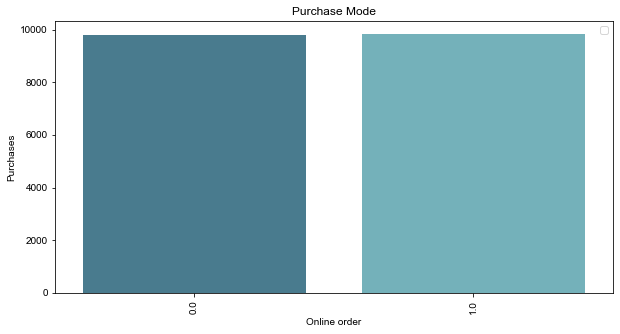

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(x='online_order',data=transaction,palette='GnBu_d')
sns.set_style('ticks')
plt.legend(loc='upper right')
plt.title("Purchase Mode")
plt.xlabel("Online order")
plt.ylabel("Purchases")
plt.xticks(rotation=90)
plt.show()

#### We observe equal shares in online and off-line sales.

In [44]:
df=transaction.sort_values(['transaction_date'], ascending=True)

Text(0, 0.5, 'Count of bicycles sold')

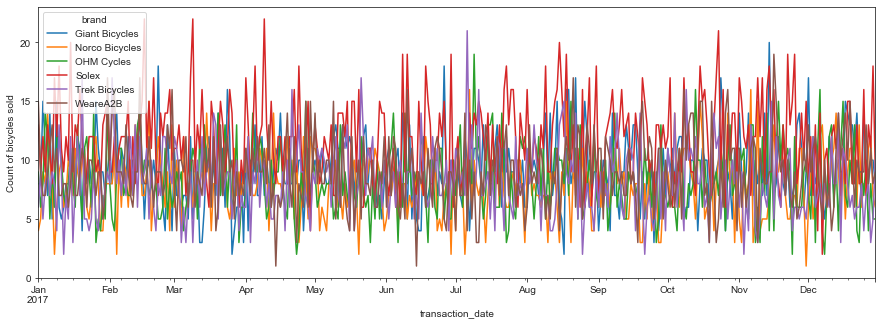

In [45]:
fig, ax = plt.subplots(figsize=(15,5))
df.groupby(['transaction_date', 'brand']).count()['transaction_id'].unstack().plot(ax=ax)
plt.ylabel("Count of bicycles sold")

<Figure size 720x360 with 0 Axes>

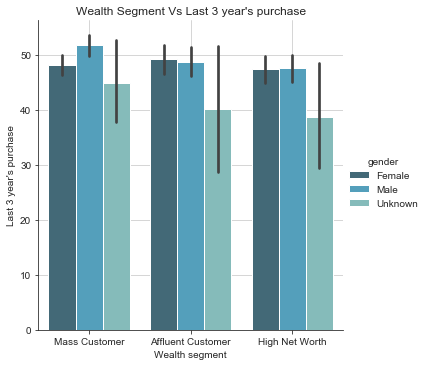

In [46]:
plt.figure(figsize=(10,5))
sns.catplot(data=merged_cust_data,x='wealth_segment',y='past_3_years_bike_related_purchases',kind='bar',hue='gender',palette='GnBu_d')
#sns.set_style('ticks')
plt.xlabel("Wealth segment")
plt.ylabel("Last 3 year's purchase")
plt.title("Wealth Segment Vs Last 3 year's purchase")
plt.grid()
plt.show()

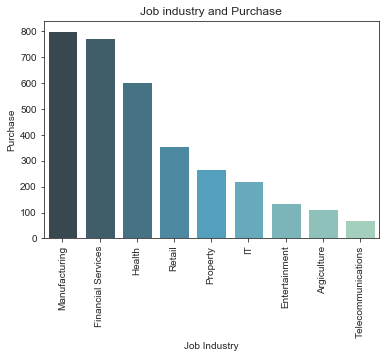

In [47]:
sns.countplot(x='job_industry_category',data=merged_cust_data,palette='GnBu_d',order = merged_cust_data['job_industry_category'].value_counts().index)
sns.set_style('ticks')
plt.title("Job industry and Purchase")
plt.xlabel("Job Industry")
plt.ylabel("Purchase")
plt.xticks(rotation=90)
plt.show()

### Age Vs Purchase

## RFM Analysis
### This is a method used for customer segmentation by considering Recency, Frequency and Money spent by a customer.

### Recency

In [48]:
recency_df=transaction.groupby(by='customer_id',as_index=False)['transaction_date'].max()
recency_df.columns=['customer_id','last_transaction_date']
recency_df.head()

customer_id last_transaction_date
0            1            2017-12-23
1            2            2017-08-24
2            3            2017-09-19
3            4            2017-06-18
4            5            2017-12-14

In [49]:
recency_df['recency']=recency_df['last_transaction_date'].apply(lambda x:(now-x).days)

### Frequency

In [50]:
frequency_df=transaction.groupby(by=['customer_id'],as_index=False)['transaction_id'].count()
frequency_df.columns=['customer_id','frequency']
frequency_df.head()

customer_id  frequency
0            1         11
1            2          3
2            3          8
3            4          2
4            5          6

### Monetary

In [51]:
monetary_df = transaction.groupby(by='customer_id',as_index=False).agg({'list_price': 'sum'})
monetary_df.columns = ['customer_id','monetary']
monetary_df.head()

customer_id  monetary
0            1   9084.45
1            2   4149.07
2            3   9888.23
3            4   1047.72
4            5   5903.20

In [52]:
rfmtable=recency_df.merge(frequency_df,on='customer_id')
rfmtable.set_index('customer_id',inplace=True)
rfmtable=rfmtable.merge(monetary_df,on='customer_id')

In [53]:
rfmtable.drop('last_transaction_date',axis=1,inplace=True)

In [55]:
quantiles = rfmtable.quantile(q=[0.25,0.50,0.75])
quantiles.drop('customer_id', axis=1, inplace=True)

In [56]:
quantiles

recency  frequency   monetary
0.25   1013.0        4.0  4198.3900
0.50   1040.0        6.0  6026.8000
0.75   1081.0        7.0  8208.8375

In [57]:
quantiles['recency'][0.25]

1013.0

## RFM Scores
#### Customer who purchased most recently => R = 1 (high recency score)
#### Customer who purchased most frequently => F = 1 (high frequency score)
#### Customer who spent the most => M = 1 (high monetary score)
#### So, a customer with RFM score 111 is treated as the best customer 

In [58]:
def RClass(score,quantile_value):
    if score<=quantile_value['recency'][0.25]:
        return 1
    elif score<=quantile_value['recency'][0.5]:
        return 2
    elif score<=quantile_value['recency'][0.75]:
        return 3
    else:
        return 4
def FClass(score,quantile_value):
    if score<=quantile_value['frequency'][0.25]:
        return 4
    elif score<=quantile_value['frequency'][0.5]:
        return 3
    elif score<=quantile_value['frequency'][0.75]:
        return 2
    else:
        return 1
def MClass(score,quantile_value):
    if score<=quantile_value['monetary'][0.25]:
        return 4
    elif score<=quantile_value['monetary'][0.5]:
        return 3
    elif score<=quantile_value['monetary'][0.75]:
        return 2
    else:
        return 1
    

In [59]:
rfmtable['R_Quartile'] = rfmtable['recency'].apply(RClass, args=(quantiles,))
rfmtable['F_Quartile'] = rfmtable['frequency'].apply(FClass, args=(quantiles,))
rfmtable['M_Quartile'] = rfmtable['monetary'].apply(MClass, args=(quantiles,))

In [60]:
rfmtable['RFMScore']=(rfmtable.R_Quartile).map(str)+(rfmtable.F_Quartile).map(str)+(rfmtable.M_Quartile).map(str)

In [61]:
rfmtable.head()

customer_id  recency  frequency  monetary  R_Quartile  F_Quartile  \
0            1     1003         11   9084.45           1           1   
1            2     1124          3   4149.07           4           4   
2            3     1098          8   9888.23           4           1   
3            4     1191          2   1047.72           4           4   
4            5     1012          6   5903.20           1           3   

   M_Quartile RFMScore  
0           1      111  
1           4      444  
2           1      411  
3           4      444  
4           3      133

In [62]:
merged_cust_data.head()

customer_id      first_name  last_name  gender  \
0            1         Laraine  Medendorp  Female   
1            2             Eli    Bockman    Male   
2            4          Talbot        NaN    Male   
3            5  Sheila-kathryn     Calton  Female   
4            6            Curr  Duckhouse    Male   

   past_3_years_bike_related_purchases               job_title  \
0                                   93     Executive Secretary   
1                                   81  Administrative Officer   
2                                   33                     NaN   
3                                   56           Senior Editor   
4                                   35                     NaN   

  job_industry_category     wealth_segment deceased_indicator owns_car  \
0                Health      Mass Customer                  N      Yes   
1    Financial Services      Mass Customer                  N      Yes   
2                    IT      Mass Customer                  N       No   
3                   NaN  Affluent Customer                  N      Yes   
4                Retail     High Net Worth                  N      Yes   

   tenure   age              address  postcode state  property_valuation  
0    11.0  66.0   060 Morning Avenue      2016   NSW                  10  
1    16.0  39.0  6 Meadow Vale Court      2153   NSW                  10  
2     7.0  58.0   0 Holy Cross Court      4211   QLD                   9  
3     8.0  43.0  17979 Del Mar Point      2448   NSW                   4  
4    13.0  54.0     9 Oakridge Court      3216   VIC                   9

In [72]:
aus_geo=pd.read_csv("australian_postcodes.csv")
postcode_df =aus_geo[["postcode","long","lat"]].drop_duplicates(subset='postcode',keep='first')

In [73]:
merged_cust_data = merged_cust_data.merge(rfmtable,on='customer_id')

In [74]:
# drop records where the age is more than 100 yrs
merged_cust_data.drop(merged_cust_data[merged_cust_data['age'] > 100].index,inplace=True)
merged_cust_data.shape

(3488, 34)

In [75]:
#get the latitude and longitude for the post-codes
merged_cust_data=pd.merge(merged_cust_data,postcode_df,left_on='postcode',right_on='postcode')
merged_cust_data.shape

(3488, 36)

In [76]:
merged_cust_data.to_excel("merged_cust_data.xlsx")

### Locate these data points on the map

In [77]:
df_cluster=merged_cust_data[["first_name","age","long","lat"]]

m = folium.Map(location=[-33.86, 151.21], tiles='openstreetmap', zoom_start=3.5)
mc=MarkerCluster()

for idx,row in df_cluster.iterrows():
    if not math.isnan(row['long']) and not math.isnan(row['lat']):
        mc.add_child(folium.Marker([row['lat'], row['long']], popup=[row['first_name'],row["age"]]))

m.add_child(mc)
m


### Coropleth

In [78]:
state_count=merged_cust_data[['state','customer_id']].groupby('state',as_index = False).count()
state_count.rename(columns={"customer_id":"count"},inplace=True)

In [65]:
state_count

state  count
0   NSW   1866
1   QLD    742
2   VIC    880

In [66]:
aus_state='australian-states_edit.json'
m=folium.Map(location=[-23.69, 133.88],zoom_start=4)

# Add the color for the chloropleth:
choropleth = folium.Choropleth(
    geo_data=aus_state,
    name='choropleth',
    data=state_count,
    columns=['state','count'],
    key_on='feature.properties.STATE_NAME',
    fill_color='Dark2',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Customer Distribution'
    ).add_to(m)
folium.LayerControl().add_to(m)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields = ['STATE_NAME'],aliases=['State'],style=('background-color: grey; color: white;')))

m

### Spending capacity of different age groups

In [79]:
merged_cust_data.head(10)

customer_id  first_name      last_name  gender  \
0            1     Laraine      Medendorp  Female   
1         1059     Chantal         Plante  Female   
2         2172      Emmery        Angrock    Male   
3         2380     Merissa        Milella  Female   
4         2768      Forest       Knowling    Male   
5            2         Eli        Bockman    Male   
6           24         Kim         Skpsey  Female   
7           65        Yale         Tanser    Male   
8           78        Arch  Van der Kruis    Male   
9          216  Cinderella        Parcall  Female   

   past_3_years_bike_related_purchases                             job_title  \
0                                   93                   Executive Secretary   
1                                   68            Account Representative III   
2                                    6           Information Systems Manager   
3                                   44                      Technical Writer   
4                                   86                   Executive Secretary   
5                                   81                Administrative Officer   
6                                   55                  Research Assistant I   
7                                   21           Information Systems Manager   
8                                   37  Business Systems Development Analyst   
9                                   12                      Quality Engineer   

  job_industry_category     wealth_segment deceased_indicator owns_car  \
0                Health      Mass Customer                  N      Yes   
1         Entertainment     High Net Worth                  N      Yes   
2                Health  Affluent Customer                  N      Yes   
3                Retail      Mass Customer                  N      Yes   
4         Manufacturing      Mass Customer                  N       No   
5    Financial Services      Mass Customer                  N      Yes   
6           Argiculture      Mass Customer                  N      Yes   
7    Financial Services  Affluent Customer                  N      Yes   
8           Argiculture  Affluent Customer                  N       No   
9    Financial Services     High Net Worth                  N      Yes   

   tenure   age                 address  postcode state  property_valuation  \
0    11.0  66.0      060 Morning Avenue      2016   NSW                  10   
1     6.0  52.0  1149 Riverside Parkway      2016   NSW                  11   
2    13.0  41.0        698 Lunder Point      2016   NSW                  10   
3    15.0  64.0             4 Judy Park      2016   NSW                  10   
4     3.0  24.0      9 Cascade Junction      2016   NSW                  12   
5    16.0  39.0     6 Meadow Vale Court      2153   NSW                  10   
6    15.0  42.0        3 Cordelia Plaza      2153   NSW                  10   
7    15.0  44.0       308 Jana Crossing      2153   NSW                  10   
8     8.0  35.0     97455 Loeprich Lane      2153   NSW                   9   
9     7.0  25.0         231 Havey Court      2153   NSW                  10   

   recency_x  frequency_x  monetary_x  R_Quartile_x  F_Quartile_x  \
0       1003           11     9084.45             1             1   
1       1018            2     2449.81             2             4   
2       1025            4     6844.50             2             4   
3       1038            7     7948.44             2             2   
4       1019            6     6811.94             2             3   
5       1124            3     4149.07             4             4   
6       1013            8     8078.95             1             1   
7       1132            6     8056.47             4             3   
8       1207            2     1139.12             4             4   
9       1012            5     5830.97             1             3   

   M_Quartile_x RFMScore_x      long_x      lat_x      long_y      lat_y  \
0             1  

In [80]:
merged_cust_data['bin'] = pd.cut(merged_cust_data['age'], [0,10,20,30,40,50,60,70,80,90,100], labels=['0-10', '10-20', '20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])

In [83]:
age_purchase=merged_cust_data.groupby('bin',as_index=False).agg({'monetary':np.sum})

SpecificationError: nested renamer is not supported

In [82]:
fig = px.pie(age_purchase, values='monetary', names='bin', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

NameError: name 'age_purchase' is not defined

In [84]:
wealthsegment_purchase=merged_cust_data.groupby('wealth_segment',as_index=False).agg({'monetary':np.sum})
wealthsegment_purchase

SpecificationError: nested renamer is not supported

In [72]:
fig = px.pie(wealthsegment_purchase, values='monetary', names='wealth_segment', color='wealth_segment',
             color_discrete_map={'Affluent Customer':'darkblue',
                                 'High Net Worth':'cyan',
                                 'Mass Customer':'royalblue'})
fig.show()

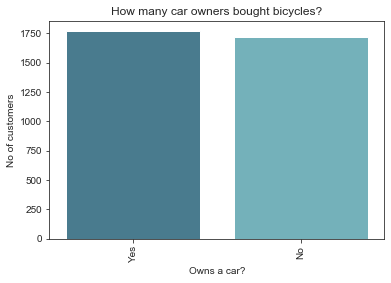

In [85]:
sns.countplot(x='owns_car',data=merged_cust_data,palette='GnBu_d')
sns.set_style('ticks')
plt.title("How many car owners bought bicycles?")
plt.xlabel("Owns a car?")
plt.ylabel("No of customers")
plt.xticks(rotation=90)
plt.show()

### Distance from capital cities

In [86]:
sydney = [{'lat': -33.8688, 'lng': 151.2093}]
melbourne = [{'lat': -37.840935, 'lng': 144.946457}]
brisbane = [{'lat': -27.470125, 'lng': 151.2093}]

sydney_tuple = tuple(sydney[0].values())
melbourne_tuple = tuple(melbourne[0].values())
brisbane_tuple = tuple(brisbane[0].values())

radius1 = 40 # in kilometer
radius2 = 80 # in kilometer

def zones(latitude,longitude,state):
    test_point = [{'lat': latitude, 'lng': longitude}]
    test_point_tuple = tuple(test_point[0].values())
    
    if state == 'NSW':
        dist=distance.distance(sydney_tuple, test_point_tuple).km
        if(dist<=radius1):
            return 'Within 40kms'
        elif(dist>radius1 and dist<=radius2):
            return '40-80 kms'
        else:
            return 'More than 80kms'
    elif state == 'QLD':
        dist=distance.distance(brisbane_tuple, test_point_tuple).km
        if(dist<=radius1):
            return 'Within 40kms'
        elif(dist>radius1 and dist<=radius2):
            return '40-80 kms'
        else:
            return 'More than 80kms'
    elif state == 'VIC':
        dist=distance.distance(melbourne_tuple, test_point_tuple).km
        if(dist<=radius1):
            return 'Within 40kms'
        elif(dist>radius1 and dist<=radius2):
            return '40-80 kms'
        else:
            return 'More than 80kms'

In [87]:
for index, row in merged_cust_data.iterrows():
    merged_cust_data.loc[index,'distance_capital']= zones(row["lat"], row["long"],row["state"])

In [88]:
merged_cust_data.shape

(3488, 38)

In [77]:
def segment(r,f,m):
    if(r==1 and f==1 and m==1):
        return 1 #'Best Customer'
    elif((r==2 or r==3) and f==1 and m==1):
        return 5 #'Almost Lost'
    elif(r==4 and (f==2 or f==3) and m==1):
        return 6 #'Lost Customer'
    elif(r==4 and f==4 and m==4):
        return 7 #'Customer with least value'
    elif((r==2 or r==3) and (f==2 or f==3) and (m==2 or m==3)):
        return 4 #'economical customer'
    elif(f==1 and m!=1):
        return 3 #'Loyal Customer'
    elif(m==1):
        return 2 #'Big Spenders'
    else:
        return 8 #'Others'
for index, row in merged_cust_data.iterrows():
    merged_cust_data.loc[index,'segment']= segment(row["R_Quartile"], row["F_Quartile"],row["M_Quartile"])

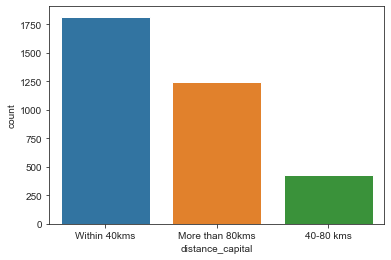

In [78]:
sns.countplot(data=merged_cust_data, x='distance_capital')

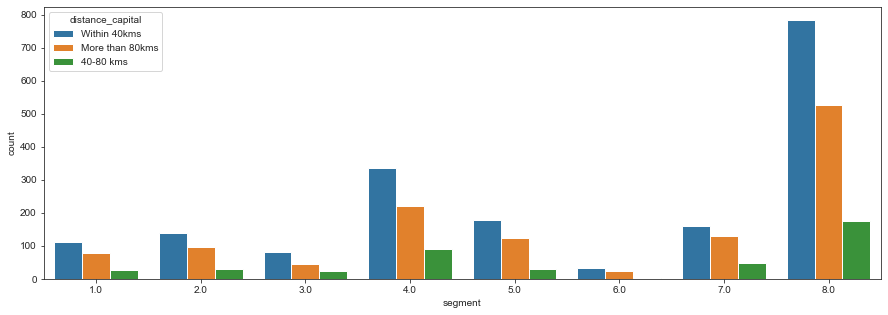

In [79]:
plt.figure(figsize=(15,5))
sns.countplot(data=merged_cust_data, x='segment',hue='distance_capital')

In [80]:
merged_cust_data.query("segment==8")['RFMScore'].unique()

array(['244', '242', '432', '133', '334', '344', '343', '144', '443',
       '342', '132', '433', '143', '122', '134', '243', '422', '234',
       '123', '142', '434', '423', '224', '324', '442', '124', '424'],
      dtype=object)

In [81]:
merged_cust_data=merged_cust_data.sample(frac=1).reset_index(drop=True)

In [82]:
merged_cust_data.shape

(3488, 28)

### Model building

In [83]:
#Dummy Variables
#Independent variables
x=merged_cust_data[['past_3_years_bike_related_purchases','job_industry_category','wealth_segment','property_valuation','state','bin','distance_capital']]
x=pd.get_dummies(x)
x.head()

past_3_years_bike_related_purchases  property_valuation  \
0                                   58                   7   
1                                   32                   7   
2                                    8                   4   
3                                   10                   3   
4                                   92                   6   

   job_industry_category_Argiculture  job_industry_category_Entertainment  \
0                                  0                                    0   
1                                  0                                    0   
2                                  0                                    0   
3                                  0                                    1   
4                                  0                                    0   

   job_industry_category_Financial Services  job_industry_category_Health  \
0                                         0                             0   
1                                         0                             0   
2                                         0                             0   
3                                         0                             0   
4                                         0                             0   

   job_industry_category_IT  job_industry_category_Manufacturing  \
0                         0                                    1   
1                         0                                    1   
2                         0                                    0   
3                         0                                    0   
4                         0                                    0   

   job_industry_category_Property  job_industry_category_Retail  \
0                               0                             0   
1                               0                             0   
2                               0                             0   
3                               0                             0   
4                               0                             0   

   job_industry_category_Telecommunications  wealth_segment_Affluent Customer  \
0                                         0                                 1   
1                                         0                                 0   
2                                         0                                 1   
3                                         0                                 0   
4                                         0                                 0   

   wealth_segment_High Net Worth  wealth_segment_Mass Customer  state_NSW  \
0                              0                             0          0   
1                              0                             1          0   
2                              0                             0          0   
3                              1                             0          0   
4                              1                             0          0   

   state_QLD  state_VIC  bin_0-10  bin_10-20  bin_20-30  bin_30-40  bin_40-50  \
0          1          0         0          0          1          0          0   
1          0          1         0          0          0          1          0   
2          1          0         0          0          0          0          1   
3          1          0         0          0          0          0          1   
4          0          1         0          0          0          0          1   

   bin_50-60  bin_60-70  bin_70-80  bin_80-90  bin_90-100  \
0          0          0          0          0           0   
1          0          0          0          0           0   
2          0          0          0          0           0   
3          0          0          0          0           0   
4          0          0          0          0           0   

   distance_capital_40-80 kms  distance_capital_More than 80kms  \
0                    

In [84]:
#Target Labels
y=merged_cust_data[['segment']]
y.shape

(3488, 1)

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [86]:
forest=RandomForestClassifier(n_estimators=10,random_state=2)

In [87]:
logreg=LogisticRegression()

In [88]:
X_train,X_test,y_train,y_test = train_test_split(x,y,random_state=0,test_size=0.3)

In [89]:
#SMOTE to handle class imbalance
X_train,y_train=SMOTE().fit_resample(X_train,y_train)
X_train.shape

(8496, 30)

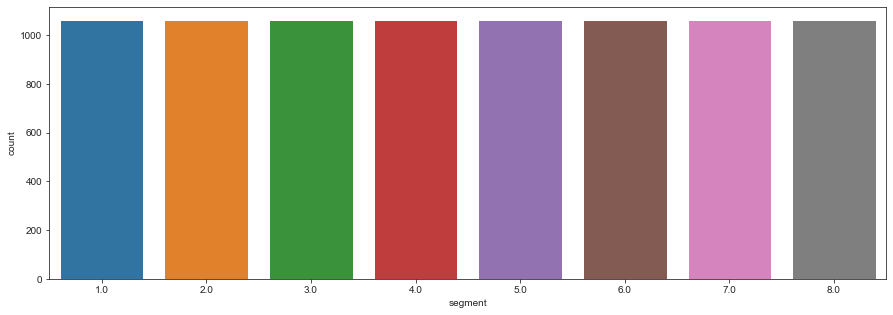

In [90]:
plt.figure(figsize=(15,5))
sns.countplot(data=y_train, x='segment')

In [91]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [92]:
scores=cross_val_score(forest,X_train,y_train,cv=10)
print(scores)

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\Users\sad

[0.26823529 0.47647059 0.64941176 0.67882353 0.66941176 0.69058824
 0.72202591 0.69729093 0.69493522 0.67962309]


In [93]:
scores=cross_val_score(logreg,X_train,y_train,cv=5)
print(scores)

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\ut

[0.20882353 0.32254267 0.30723955 0.30370806 0.30311948]


In [94]:
#Parameter setting
param_grid={'C':[0.01,0.01,0.1,1,10,100],
           'gamma':[0.01,0.01,0.1,1,10,100]}

In [95]:
grid_search=GridSearchCV(SVC(),param_grid,cv=5)

In [96]:
grid_search.fit(X_train,y_train)

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\ut

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\ut

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\ut

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\ut

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\ut

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\sada0419\Anaconda3\lib\site-packages\sklearn\ut

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.01, 0.1, 1, 10, 100]})

In [97]:
print(grid_search.score(X_test,y_test))

0.37249283667621774


#### Final model: Random Forest

In [98]:
model=forest.fit(X_train,y_train)

C:\Users\sada0419\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [99]:
y_train

segment
0         8.0
1         4.0
2         8.0
3         7.0
4         4.0
...       ...
8491      7.0
8492      7.0
8493      7.0
8494      7.0
8495      7.0

[8496 rows x 1 columns]

In [100]:
y_predict=model.predict(X_test)

In [101]:
accuracy=metrics.accuracy_score(y_test,y_predict)
print("Accuracy: ",accuracy)

Accuracy:  0.23973256924546324


In [102]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


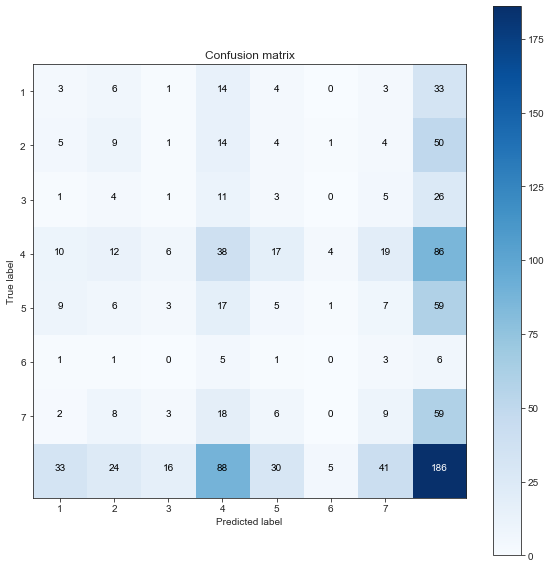

In [103]:
class_names = [i for i in range(1,8)]
cnf_matrix = confusion_matrix(y_test,y_predict) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

## Prepare new customer data to fit in the model

In [104]:
new_cust['bin'] = pd.cut(new_cust['age'], [0,10,20,30,40,50,60,70,80,90,100], labels=['0-10', '10-20', '20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])

In [105]:
new_cust=pd.merge(new_cust,postcode_df,left_on='postcode',right_on='postcode')

In [106]:
new_cust.head()

first_name last_name  gender  past_3_years_bike_related_purchases  \
0    Chickie   Brister    Male                                   86   
1      Peria  Rantoull  Female                                    3   
2    Madison      Lars    Male                                   11   
3     Andrea    Pendle  Female                                   86   
4   Philbert     Bangs    Male                                   67   

                  job_title job_industry_category  wealth_segment  \
0           General Manager         Manufacturing   Mass Customer   
1         Financial Analyst    Financial Services   Mass Customer   
2          Health Coach III                Health   Mass Customer   
3                       NaN                   NaN  High Net Worth   
4  Environmental Specialist                    IT   Mass Customer   

  deceased_indicator owns_car  tenure                  address  postcode  \
0                  N      Yes      14         45 Shopko Center      4500   
1                  N       No       4     8350 Moulton Terrace      4500   
2                  N       No      19   9503 New Castle Street      4500   
3                  N      Yes      13  31281 Meadow Valley Way      4500   
4                  N      Yes       6        02643 Moose Court      4500   

  state  property_valuation  Rank    Value   age    bin        long        lat  
0   QLD                   6     1  1.71875  63.0  60-70  152.939438 -27.307845  
1   QLD                   4   120  1.26250  45.0  40-50  152.939438 -27.307845  
2   QLD                   9   620  0.75000  53.0  50-60  152.939438 -27.307845  
3   QLD                   6   760  0.63750  82.0  80-90  152.939438 -27.307845  
4   QLD                   7   951  0.45050  54.0  50-60  152.939438 -27.307845

In [107]:
for index, row in new_cust.iterrows():
    new_cust.loc[index,'distance_capital']= zones(row["lat"], row["long"],row["state"])

In [114]:
new_unseen_cust=new_cust[['past_3_years_bike_related_purchases','job_industry_category','wealth_segment','property_valuation','state','bin','distance_capital']]

In [115]:
new_unseen_cust=pd.get_dummies(new_unseen_cust)

In [116]:
new_cust['segment']=model.predict(new_unseen_cust)

In [119]:
new_cust.to_excel('New_unseen_cust.xlsx')

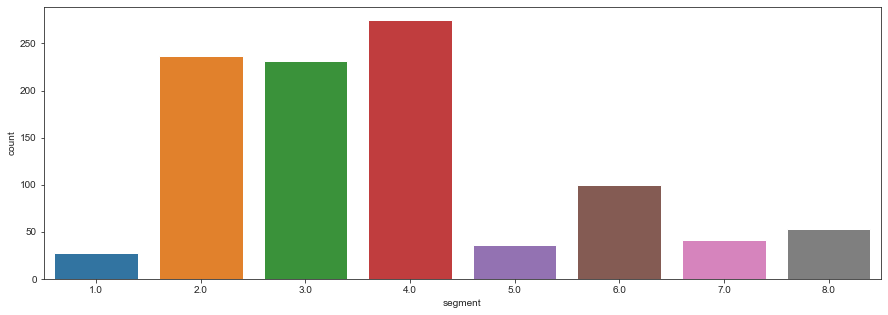

In [120]:
plt.figure(figsize=(15,5))
sns.countplot(data=new_cust, x='segment')